## Inference One Video and Visualize the Knowledge Graph.
Fast Demo: Load processed clips and do not host CNN.

In [1]:
import os
import sys
import pickle

import numpy as np
import owlready2 as owl
import graphviz
import torch
from torch.utils import data

from token2tag import *

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import v2c utils
sys.path.append(ROOT_DIR)  # To find local version of the library
from v2c.model import *
from v2c import utils
from v2c import visualize
from v2c.config import *
from datasets import rs_rgbd

In [2]:
# Configuration for hperparameters
class InferenceConfig(Config):
    """Configuration for training with RS-RGBD.
    """
    NAME = 'v2c_RS-RGBD'
    MODE = 'test'
    ROOT_DIR = ROOT_DIR
    CHECKPOINT_PATH = os.path.join(ROOT_DIR, 'checkpoints')
    DATASET_PATH = os.path.join(ROOT_DIR, 'datasets', 'RS-RGBD')
    SETTINGS = ['Evaluation']
    VIDEO_NAME = 'streamline_water_plastic_bottle1_mug4'
    CHECKPOINT_FILE = os.path.join(CHECKPOINT_PATH, 'saved','v2c_epoch_120.pth')
    ONTO_FILE = os.path.join(DATASET_PATH, 'object_onto.owl')
    
# --------------------
# Setup configuration class
config = InferenceConfig()
# Setup vocabulary
vocab = pickle.load(open(os.path.join(config.CHECKPOINT_PATH, 'vocab.pkl'), 'rb'))
config.VOCAB_SIZE = len(vocab)

# --------------------
# Init test dataset
clips, targets, _, _ = rs_rgbd.parse_clip_paths_and_captions(config, vocab, config.VIDEO_NAME)
config.display()
indices = np.argsort([int(x.split('_')[-3]) for x in clips])
clips = np.array(clips)[indices]
targets = targets[indices]

print('No. clips to evaluate:', len(clips), len(targets))
# Dataset obj
test_dataset = rs_rgbd.ClipDataset(clips, targets)
test_loader = data.DataLoader(test_dataset, 
                              batch_size=config.BATCH_SIZE, 
                              shuffle=False, 
                              num_workers=1)


Configurations:
------------------------------
BACKBONE                       {'resnet50': 2048}
BATCH_SIZE                     16
CHECKPOINT_FILE                /mnt/c/Users/Zone/Desktop/Robot_Semantics_v2/robot_semantics/checkpoints/saved/v2c_epoch_120.pth
CHECKPOINT_PATH                /mnt/c/Users/Zone/Desktop/Robot_Semantics_v2/robot_semantics/checkpoints
DATASET_PATH                   /mnt/c/Users/Zone/Desktop/Robot_Semantics_v2/robot_semantics/datasets/RS-RGBD
DISPLAY_EVERY                  20
EMBED_SIZE                     512
END_WORD                       <eos>
FREQUENCY                      None
LEARNING_RATE                  0.0001
MAXLEN                         15
MODE                           test
NAME                           v2c_RS-RGBD
NUM_EPOCHS                     150
ONTO_FILE                      /mnt/c/Users/Zone/Desktop/Robot_Semantics_v2/robot_semantics/datasets/RS-RGBD/object_onto.owl
RETRIEVAL_LIMIT                15
ROOT_DIR                       /mnt/c/Us

## Inference
Test the inference of video2command model.

In [3]:
def init_model(config, 
               vocab,
               CHECKPOINT_FILE):
    # --------------------
    # Setup and build video2command training inference
    v2c_model = Video2Command(config, vocab)
    v2c_model.build(None)
    # Safely create demo dir if non-exist
    if not os.path.exists(os.path.join(config.CHECKPOINT_PATH, 'demo', config.VIDEO_NAME)):
        os.makedirs(os.path.join(config.CHECKPOINT_PATH, 'demo', config.VIDEO_NAME))
    # Load back weights
    v2c_model.load_weights(CHECKPOINT_FILE)
    print('Model loading success.')
    return v2c_model

# --------------------
# Inference
# Save predictions and ground-truths
preds = []
trues = []
frames_no = []
if os.path.exists(config.CHECKPOINT_FILE):
    print('Loading saved model {}...'.format(config.CHECKPOINT_FILE))
    v2c_model = init_model(config, vocab, config.CHECKPOINT_FILE)

    # Evaluate
    y_pred, y_true, fnames, all_alphas = v2c_model.evaluate(test_loader)

    # Save to evaluation file
    f = open(os.path.join(config.CHECKPOINT_PATH, 'demo', config.VIDEO_NAME, 'prediction.txt'), 'w')
        
    # Loop through predictions
    for i in range(len(y_pred)):
        # Parse prediction file
        pred_command = utils.sequence_to_text(y_pred[i], vocab)
        true_command = utils.sequence_to_text(y_true[i], vocab)
        fname = fnames[i].split('_')
        start_frame_no, end_frame_no = int(fname[-3]), int(fname[-2])
        preds.append(pred_command)
        trues.append(true_command)
        frames_no.append((start_frame_no, end_frame_no))

print('Done collection.')
print(len(preds), len(trues), len(frames_no))

Loading saved model /mnt/c/Users/Zone/Desktop/Robot_Semantics_v2/robot_semantics/checkpoints/saved/v2c_epoch_120.pth...
Loading...
Model loaded.
Model loading success.
Done collection.
100 100 100


In [4]:
idx = 58
start_frame_no, end_frame_no = frames_no[idx]
pred, true = preds[idx], trues[idx]

print('Video:', config.VIDEO_NAME)
print('Starting at {}, ending at {}...'.format(start_frame_no, end_frame_no))
print('Ground-truth Command: {} \nPrediction Command: {}'.format(true, pred))

Video: streamline_water_plastic_bottle1_mug4
Starting at 870, ending at 899...
Ground-truth Command: humanhand pour cold_water from plastic_bottle to centric_mug 
Prediction Command: humanhand pour cold_water from plastic_bottle to centric_mug


## Ontology & Visualization
Here, we use the dynamic command sentence as the base knowledge graph. We loop through each word tokens(entities), retrieving known external knowledge stored inside a static ontology.

In [5]:
# --------------------
# Init ontology model
onto = utils.init_onto(config.ONTO_FILE)

Loaded owl file at: file:///mnt/c/Users/Zone/Desktop/Robot_Semantics_v2/robot_semantics/datasets/RS-RGBD/object_onto.owl


* Owlready2 * Running HermiT...
    java -Xmx2000M -cp /usr/local/lib/python3.6/dist-packages/owlready2/hermit:/usr/local/lib/python3.6/dist-packages/owlready2/hermit/HermiT.jar org.semanticweb.HermiT.cli.CommandLine -c -O -D -I file:////tmp/tmp5_zc2nyi
* Owlready2 * HermiT took 0.9425418376922607 seconds
* Owlready * Reparenting object_onto.hasEntityPresented: {owl.ObjectProperty, object_onto.topContextClassProperty} => {object_onto.topContextClassProperty}
* Owlready * Reparenting object_onto.hasGenericTemperature: {owl.ObjectProperty, object_onto.topClassProperty} => {object_onto.topClassProperty}
* Owlready * Reparenting object_onto.hasFoodInsideGeneric: {owl.ObjectProperty, object_onto.topClassProperty} => {object_onto.topClassProperty}
* Owlready * Reparenting object_onto.hasMaterial: {owl.FunctionalProperty, owl.ObjectProperty, object_onto.topClassProperty} => {owl.FunctionalProperty, object_onto.topClassProperty}
* Owlready * Reparenting object_onto.canWithstandTemperature: {ow

In [6]:
# Convert predicted command sentence into base knowledge graph
graph = utils.sentence_to_graph(pred, token2tag)
print('Base Knowledge Graph:')
print('-'*20)
print(graph)

Base Knowledge Graph:
--------------------
[('HumanHand', 'V2C_POUR', 'ColdWater'), ('PlasticBottle', 'V2C_FROM', 'ColdWater'), ('ColdWater', 'V2C_TO', 'CentricMug')]


In [7]:
# Search ontology, grab external knowledge
graph_from_onto = utils.retrieve_knowledge_graph(pred, token2tag, onto)
print()
print('External Knowledge Graph:')
print('-'*20)
print(graph_from_onto)


External Knowledge Graph:
--------------------
[('ColdWater', 'hasGenericTemperature, some', 'Cold'), ('ColdWater', 'subclass_of', 'Water'), ('Water', 'has_subclass', 'ColdWater'), ('PlasticBottle', 'hasMaterial, some', 'Plastic'), ('PlasticBottle', 'subclass_of', 'Bottle'), ('PlasticBottle', 'isGraspableBy, some', 'HumanHand'), ('PlasticBottle', 'isGraspableBy, some', 'KinovaArm'), ('PlasticBottle', 'isGraspableBy, some', 'WAMArm'), ('PlasticBottle', 'has_individual', 'OilBottle1'), ('PlasticBottle', 'has_individual', 'OilBottle2'), ('PlasticBottle', 'has_individual', 'PlasticBottle1'), ('PlasticBottle', 'has_individual', 'PlasticBottle2'), ('PlasticBottle', 'has_individual', 'PlasticBottle3'), ('PlasticBottle', 'has_individual', 'PlasticBottle4'), ('Bottle', 'has_subclass', 'PlasticBottle'), ('HumanHand', 'canGrasp, some', 'PlasticBottle'), ('KinovaArm', 'canGrasp, some', 'PlasticBottle'), ('WAMArm', 'canGrasp, some', 'PlasticBottle'), ('CentricMug', 'hasMaterial, some', 'Centric'),

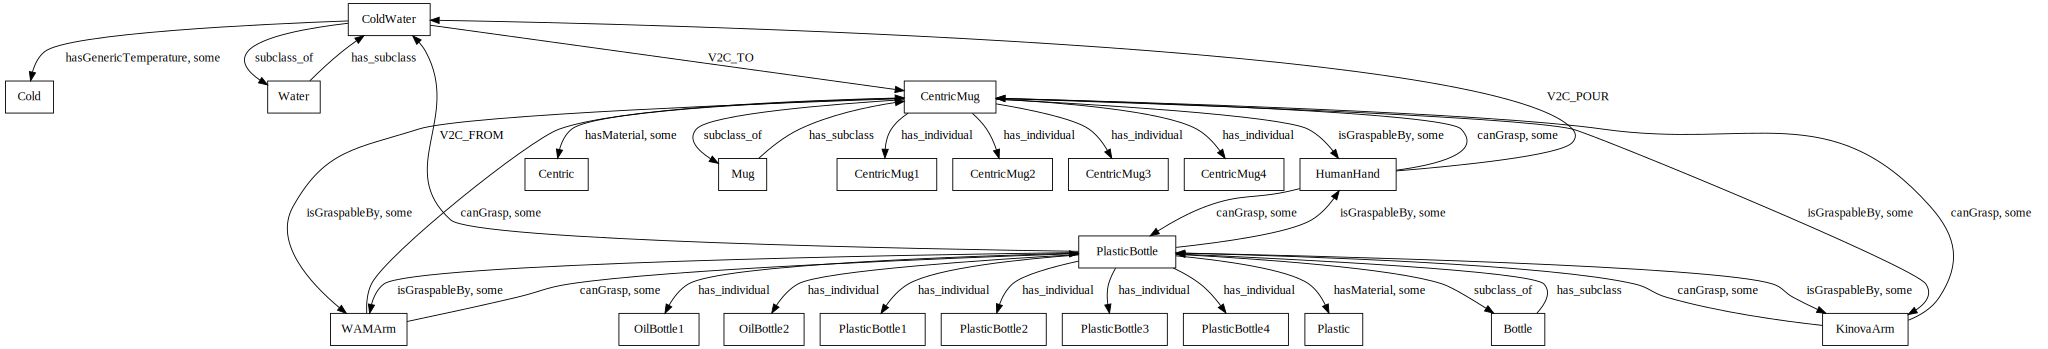

In [8]:
e = visualize.convert_to_graphviz(graph_from_onto + graph)
e.view()    # Save knowledge graph as a pdf
e